In [5]:
import os
import json
import string
import logging
import wave
from pathlib import Path
from tqdm import tqdm

# ===============================
# CONFIGURATION
# ===============================
BASE_DIR = r"C:\Users\Shristi chandra\OneDrive\Desktop\TORGO_DATASET"
OUTPUT_JSON = "dataset_info.json"
FOLDERS = ["F", "FC", "M", "MC"]

# ===============================
# SPEAKER SEVERITY (FROM TORGO PAPER)
# ===============================
SPEAKER_SEVERITY = {
    "F01": "severe",
    "M01": "severe",
    "M02": "severe",
    "M04": "severe",
    "M05": "moderate_severe",
    "F03": "moderate",
    "F04": "mild",
    "M03": "mild"
}

SEVERITY_GROUP = {
    "severe": "G1",
    "moderate_severe": "G1",
    "moderate": "G2",
    "mild": "G2"
}

# ===============================
# LOGGING
# ===============================
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

# ===============================
# UTILITY FUNCTIONS
# ===============================
def normalize_text(text: str) -> str:
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    return " ".join(text.split())


def is_valid_audio(path: Path) -> bool:
    try:
        if path.stat().st_size == 0:
            return False
        with wave.open(str(path), 'rb') as wf:
            return wf.getnframes() > 0
    except Exception:
        return False


def find_transcript(audio_path: Path):
    session_dir = audio_path.parent.parent
    prompt_dir = session_dir / "prompts"

    if not prompt_dir.exists():
        return None

    stem = audio_path.stem
    candidates = [
        f"{stem}.txt",
        f"{stem.zfill(4)}.txt",
        f"{stem.lstrip('0')}.txt"
    ]

    for c in candidates:
        p = prompt_dir / c
        if p.exists():
            return p
    return None


# ===============================
# MAIN PROCESS
# ===============================
def main():
    base_dir = Path(BASE_DIR)
    dataset = []

    for folder in FOLDERS:
        folder_path = base_dir / folder
        if not folder_path.exists():
            continue

        logging.info(f"Processing folder: {folder}")

        for wav_path in tqdm(folder_path.rglob("*.wav")):
            if not is_valid_audio(wav_path):
                continue

            transcript_path = find_transcript(wav_path)
            if transcript_path is None:
                continue

            text = transcript_path.read_text(
                encoding="utf-8", errors="ignore"
            ).strip()
            if not text:
                continue

            transcript = normalize_text(text)
            speaker_id = wav_path.parent.parent.parent.name

            # CONTROL vs DYSARTHRIC
            if folder in ["FC", "MC"]:
                severity = "control"
                severity_group = "control"
            else:
                severity = SPEAKER_SEVERITY[speaker_id]
                severity_group = SEVERITY_GROUP[severity]

            dataset.append({
                "audio_path": str(wav_path),
                "transcript": transcript,
                "speaker_id": speaker_id,
                "gender_group": folder,
                "severity": severity,
                "severity_group": severity_group
            })

    with open(OUTPUT_JSON, "w", encoding="utf-8") as f:
        json.dump(dataset, f, indent=2)

    logging.info(f"Saved {len(dataset)} samples to {OUTPUT_JSON}")


if __name__ == "__main__":
    main()


2026-01-15 23:15:05,315 - INFO - Processing folder: F
2391it [00:00, 5279.87it/s]
2026-01-15 23:15:05,784 - INFO - Processing folder: FC
4678it [00:00, 5354.34it/s]
2026-01-15 23:15:06,672 - INFO - Processing folder: M
3788it [00:00, 4965.69it/s]
2026-01-15 23:15:07,436 - INFO - Processing folder: MC
6778it [00:01, 4824.45it/s]
2026-01-15 23:15:08,960 - INFO - Saved 17253 samples to dataset_info.json


In [8]:
pip install pandas matplotlib seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


Total samples: 17253
                                          audio_path  \
0  C:\Users\Shristi chandra\OneDrive\Desktop\TORG...   
1  C:\Users\Shristi chandra\OneDrive\Desktop\TORG...   
2  C:\Users\Shristi chandra\OneDrive\Desktop\TORG...   
3  C:\Users\Shristi chandra\OneDrive\Desktop\TORG...   
4  C:\Users\Shristi chandra\OneDrive\Desktop\TORG...   

                                transcript speaker_id gender_group severity  \
0                    say ahpeee repeatedly        F01            F   severe   
1                    say ahpeee repeatedly        F01            F   severe   
2                 say pahtahkah repeatedly        F01            F   severe   
3                    say eeepah repeatedly        F01            F   severe   
4  relax your mouth in its normal position        F01            F   severe   

  severity_group  
0             G1  
1             G1  
2             G1  
3             G1  
4             G1  


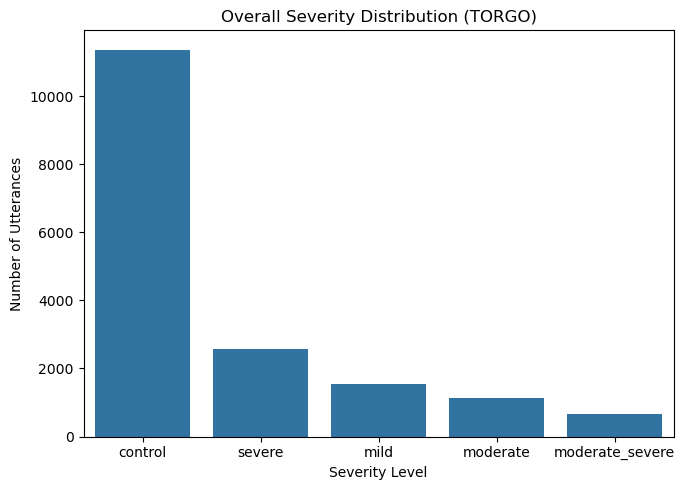

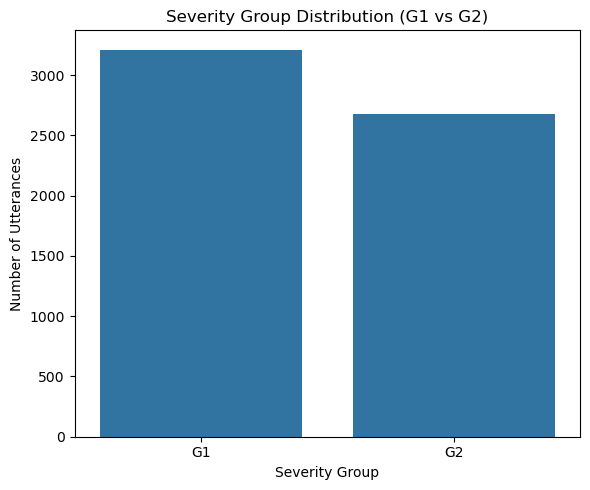

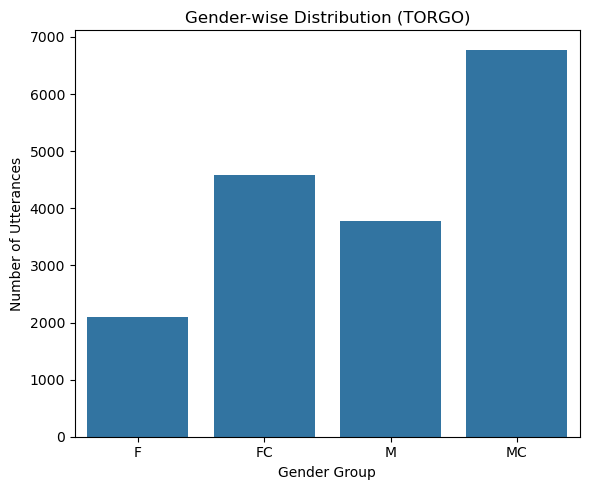

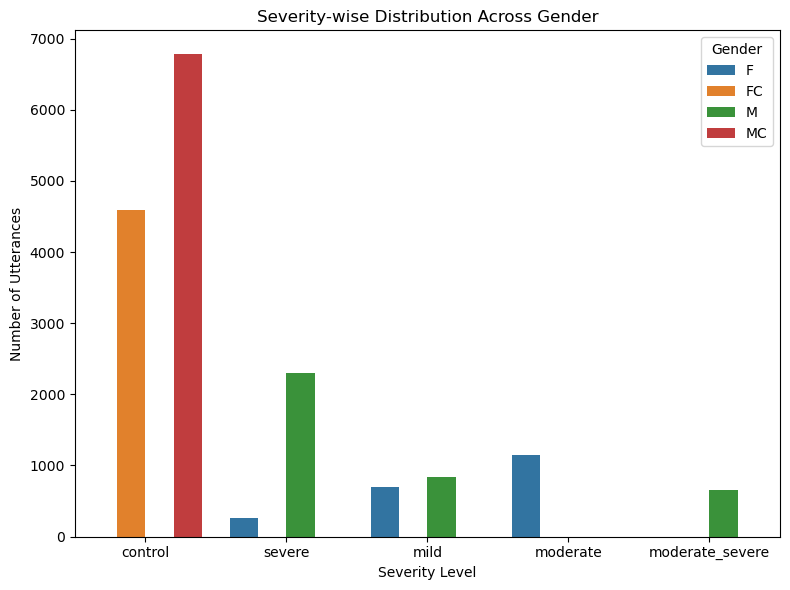

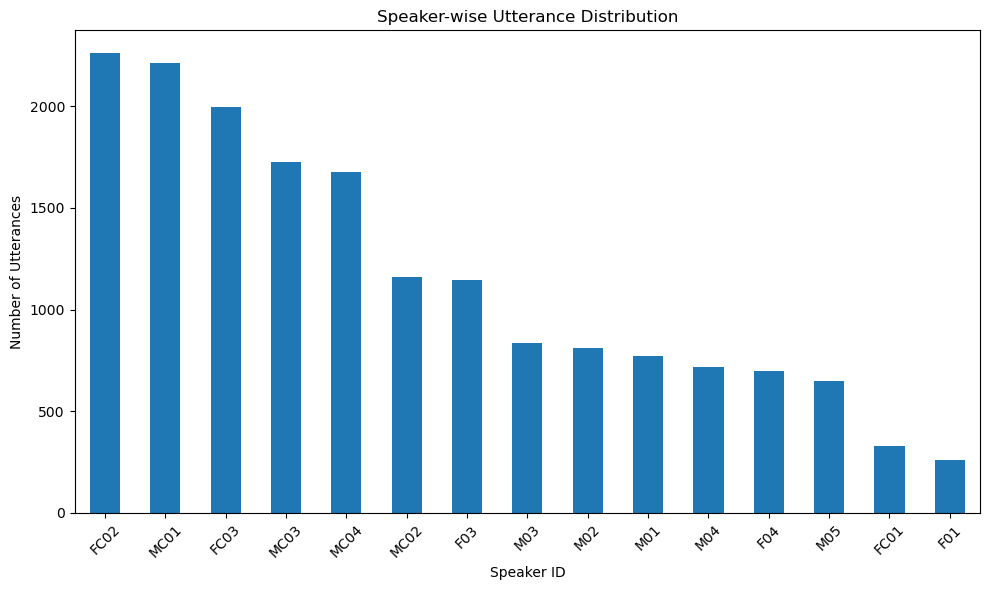

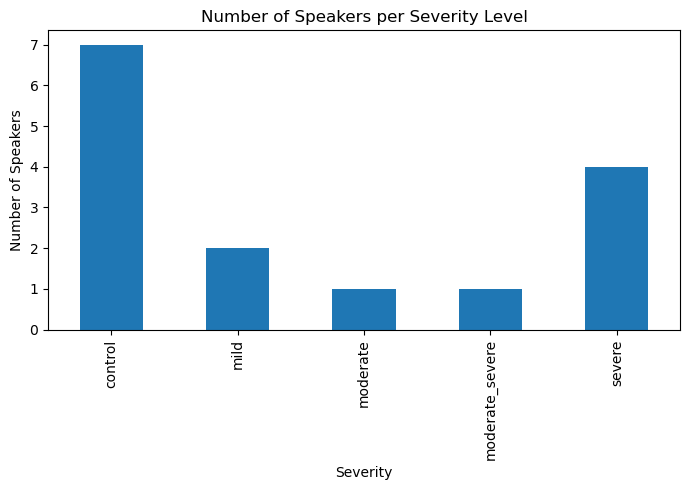


Severity-wise Summary:
                 total_utterances  unique_speakers
severity                                          
control                     11362                7
mild                         1534                2
moderate                     1145                1
moderate_severe               651                1
severe                       2561                4


In [6]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ===============================
# CONFIG
# ===============================
DATASET_JSON = "dataset_info.json"
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

# ===============================
# LOAD DATA
# ===============================
with open(DATASET_JSON, "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)

print("Total samples:", len(df))
print(df.head())

# ===============================
# 1️⃣ OVERALL SEVERITY DISTRIBUTION
# ===============================
plt.figure(figsize=(7,5))
sns.countplot(data=df, x="severity", order=df["severity"].value_counts().index)
plt.title("Overall Severity Distribution (TORGO)")
plt.xlabel("Severity Level")
plt.ylabel("Number of Utterances")
plt.tight_layout()
plt.savefig(FIG_DIR / "severity_distribution.png")
plt.show()

# ===============================
# 2️⃣ SEVERITY GROUP (G1 vs G2)
# ===============================
plt.figure(figsize=(6,5))
sns.countplot(data=df, x="severity_group", order=["G1", "G2"])
plt.title("Severity Group Distribution (G1 vs G2)")
plt.xlabel("Severity Group")
plt.ylabel("Number of Utterances")
plt.tight_layout()
plt.savefig(FIG_DIR / "severity_group_distribution.png")
plt.show()

# ===============================
# 3️⃣ GENDER-WISE DISTRIBUTION
# ===============================
plt.figure(figsize=(6,5))
sns.countplot(data=df, x="gender_group")
plt.title("Gender-wise Distribution (TORGO)")
plt.xlabel("Gender Group")
plt.ylabel("Number of Utterances")
plt.tight_layout()
plt.savefig(FIG_DIR / "gender_distribution.png")
plt.show()

# ===============================
# 4️⃣ SEVERITY × GENDER DISTRIBUTION
# ===============================
plt.figure(figsize=(8,6))
sns.countplot(
    data=df,
    x="severity",
    hue="gender_group",
    order=df["severity"].value_counts().index
)
plt.title("Severity-wise Distribution Across Gender")
plt.xlabel("Severity Level")
plt.ylabel("Number of Utterances")
plt.legend(title="Gender")
plt.tight_layout()
plt.savefig(FIG_DIR / "severity_by_gender.png")
plt.show()

# ===============================
# 5️⃣ SPEAKER-WISE DISTRIBUTION
# ===============================
speaker_counts = df.groupby("speaker_id").size().sort_values(ascending=False)

plt.figure(figsize=(10,6))
speaker_counts.plot(kind="bar")
plt.title("Speaker-wise Utterance Distribution")
plt.xlabel("Speaker ID")
plt.ylabel("Number of Utterances")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIG_DIR / "speaker_distribution.png")
plt.show()

# ===============================
# 6️⃣ SEVERITY-WISE SPEAKER COUNT
# ===============================
severity_speaker = (
    df.groupby(["severity", "speaker_id"])
      .size()
      .reset_index()
      .groupby("severity")
      .size()
)

plt.figure(figsize=(7,5))
severity_speaker.plot(kind="bar")
plt.title("Number of Speakers per Severity Level")
plt.xlabel("Severity")
plt.ylabel("Number of Speakers")
plt.tight_layout()
plt.savefig(FIG_DIR / "severity_speaker_count.png")
plt.show()

# ===============================
# SUMMARY TABLE (FOR PAPER)
# ===============================
summary = df.groupby("severity").agg(
    total_utterances=("audio_path", "count"),
    unique_speakers=("speaker_id", "nunique")
)

print("\nSeverity-wise Summary:")
print(summary)

summary.to_csv(FIG_DIR / "severity_summary.csv")


In [1]:
# ============================================================
# FINAL LOG-MEL FEATURE EXTRACTION (TORGO, WINDOWS-SAFE)
# ============================================================

import json
import numpy as np
import torch
import audioread
import torchaudio.transforms as T
from pathlib import Path
from tqdm import tqdm

# ===============================
# CONFIGURATION
# ===============================
DATASET_JSON = "dataset_info.json"
FEATURE_DIR = Path("features_logmel")
FEATURE_DIR.mkdir(exist_ok=True)

SAMPLE_RATE = 16000
N_MELS = 80
N_FFT = 512
WIN_LENGTH = int(0.025 * SAMPLE_RATE)   # 25 ms
HOP_LENGTH = int(0.010 * SAMPLE_RATE)   # 10 ms

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ===============================
# LOAD DATASET METADATA
# ===============================
with open(DATASET_JSON, "r", encoding="utf-8") as f:
    dataset = json.load(f)

print("Total samples:", len(dataset))

# ===============================
# MEL + dB TRANSFORMS
# ===============================
mel_transform = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=N_FFT,
    win_length=WIN_LENGTH,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS,
    power=2.0
).to(DEVICE)

db_transform = T.AmplitudeToDB(stype="power").to(DEVICE)

# ===============================
# AUDIO LOADER (audioread ONLY)
# ===============================
def load_audio(path):
    samples = []
    with audioread.audio_open(path) as f:
        sr = f.samplerate
        for buf in f:
            data = np.frombuffer(buf, dtype=np.int16)
            samples.append(data)

    if len(samples) == 0:
        raise ValueError("Empty audio")

    y = np.concatenate(samples).astype(np.float32)

    # TORGO is already 16kHz; enforce check
    if sr != SAMPLE_RATE:
        raise ValueError("Sample rate mismatch")

    # 🔴 Skip very short utterances (FIXES YOUR ERROR)
    if len(y) < WIN_LENGTH:
        raise ValueError("Audio too short")

    y = y / (np.max(np.abs(y)) + 1e-8)
    return torch.tensor(y, dtype=torch.float32).unsqueeze(0).to(DEVICE)

# ===============================
# FEATURE EXTRACTION
# ===============================
feature_metadata = []
skipped = 0

for item in tqdm(dataset, desc="Extracting Log-Mel features"):
    audio_path = item["audio_path"]
    speaker_id = item["speaker_id"]
    utt_id = Path(audio_path).stem

    try:
        waveform = load_audio(audio_path)
        mel = mel_transform(waveform)
        logmel = db_transform(mel).squeeze(0)   # (80, T)

    except Exception:
        skipped += 1
        continue

    feat_path = FEATURE_DIR / f"{speaker_id}_{utt_id}.npy"
    np.save(feat_path, logmel.cpu().numpy())

    feature_metadata.append({
        "feature_path": str(feat_path),
        "speaker_id": speaker_id,
        "severity": item["severity"],
        "severity_group": item["severity_group"]
    })

# ===============================
# SAVE FEATURE METADATA
# ===============================
with open("features_metadata.json", "w", encoding="utf-8") as f:
    json.dump(feature_metadata, f, indent=2)

print("✅ Feature extraction completed")
print(f"✅ Saved features: {len(feature_metadata)}")
print(f"⚠️ Skipped short/invalid utterances: {skipped}")


Total samples: 17253


Extracting Log-Mel features: 100%|██████████| 17253/17253 [02:32<00:00, 112.80it/s]


✅ Feature extraction completed
✅ Saved features: 17233
⚠️ Skipped short/invalid utterances: 20


In [3]:
# ============================================================
# STEP 1: LOSO SPLIT (Severity-aware, TORGO)
# ============================================================

import json
from pathlib import Path
from collections import defaultdict

# ===============================
# CONFIG
# ===============================
FEATURE_META_JSON = "features_metadata.json"
OUTPUT_DIR = Path("loso_splits")
OUTPUT_DIR.mkdir(exist_ok=True)

# ===============================
# LOAD FEATURE METADATA
# ===============================
with open(FEATURE_META_JSON, "r", encoding="utf-8") as f:
    data = json.load(f)

print(f"Total feature samples: {len(data)}")

# ===============================
# KEEP ONLY DYSARTHRIC DATA
# ===============================
data = [d for d in data if d["severity"] != "control"]

print(f"Dysarthric samples: {len(data)}")

# ===============================
# GROUP BY SPEAKER
# ===============================
speaker_dict = defaultdict(list)
for item in data:
    speaker_dict[item["speaker_id"]].append(item)

speakers = sorted(speaker_dict.keys())

print(f"Total dysarthric speakers: {len(speakers)}")
print("Speakers:", speakers)

# ===============================
# LOSO SPLIT
# ===============================
for test_speaker in speakers:

    train_samples = []
    test_samples = speaker_dict[test_speaker]

    for spk in speakers:
        if spk != test_speaker:
            train_samples.extend(speaker_dict[spk])

    # -------------------------------
    # SAVE SPLIT
    # -------------------------------
    split_dir = OUTPUT_DIR / f"test_{test_speaker}"
    split_dir.mkdir(exist_ok=True)

    with open(split_dir / "train.json", "w", encoding="utf-8") as f:
        json.dump(train_samples, f, indent=2)

    with open(split_dir / "test.json", "w", encoding="utf-8") as f:
        json.dump(test_samples, f, indent=2)

    print(
        f"✔ LOSO Split | Test Speaker: {test_speaker} | "
        f"Train: {len(train_samples)} | Test: {len(test_samples)}"
    )

print("\n✅ LOSO splitting completed successfully.")
print(f"📁 Splits saved in: {OUTPUT_DIR}")


Total feature samples: 17233
Dysarthric samples: 5871
Total dysarthric speakers: 8
Speakers: ['F01', 'F03', 'F04', 'M01', 'M02', 'M03', 'M04', 'M05']
✔ LOSO Split | Test Speaker: F01 | Train: 5609 | Test: 262
✔ LOSO Split | Test Speaker: F03 | Train: 4726 | Test: 1145
✔ LOSO Split | Test Speaker: F04 | Train: 5173 | Test: 698
✔ LOSO Split | Test Speaker: M01 | Train: 5099 | Test: 772
✔ LOSO Split | Test Speaker: M02 | Train: 5062 | Test: 809
✔ LOSO Split | Test Speaker: M03 | Train: 5035 | Test: 836
✔ LOSO Split | Test Speaker: M04 | Train: 5153 | Test: 718
✔ LOSO Split | Test Speaker: M05 | Train: 5240 | Test: 631

✅ LOSO splitting completed successfully.
📁 Splits saved in: loso_splits


In [33]:
import gc, torch

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()


In [30]:
# ============================================================
# FINAL BASELINE CONFORMER (ROBUST & PAPER-READY)
# TORGO DATASET | LOSO | SEVERITY CLASSIFICATION
# Training + Evaluation (F1, CM, SER, WER, CER)
# ============================================================

import json, time
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchaudio.models import Conformer
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# ===============================
# CONFIG
# ===============================
PROJECT_ROOT = Path(".")
LOSO_DIR = PROJECT_ROOT / "loso_splits"
CKPT_DIR = PROJECT_ROOT / "checkpoints_baseline_final"
CKPT_DIR.mkdir(exist_ok=True)

RESULTS_JSON = PROJECT_ROOT / "baseline_final_loso_results.json"

BATCH_SIZE = 4
MAX_EPOCHS = 60
PATIENCE = 5
MIN_DELTA = 1e-3
LR = 1e-4
MAX_LEN = 800

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Device: {DEVICE}")

# ===============================
# LABEL MAP
# ===============================
severity_map = {
    "mild": 0,
    "moderate": 1,
    "moderate_severe": 1,
    "severe": 2
}
inv_map = {0: "mild", 1: "moderate", 2: "severe"}
CLASS_NAMES = ["mild", "moderate", "severe"]
ALL_LABELS = [0, 1, 2]

# ===============================
# DATASET
# ===============================
class FeatureDataset(Dataset):
    def __init__(self, json_path):
        with open(json_path) as f:
            self.data = json.load(f)
        self.labels = [severity_map[d["severity"]] for d in self.data]
        self.class_counts = Counter(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        feat = np.load(item["feature_path"]).T[:MAX_LEN]
        return (
            torch.tensor(feat, dtype=torch.float32),
            feat.shape[0],
            severity_map[item["severity"]]
        )

def collate_fn(batch):
    feats, lengths, labels = zip(*batch)
    return (
        pad_sequence(feats, batch_first=True),
        torch.tensor(lengths),
        torch.tensor(labels)
    )

# ===============================
# MODEL
# ===============================
def masked_mean(x, lengths):
    max_len = x.size(1)
    mask = torch.arange(max_len, device=x.device)[None, :] < lengths[:, None]
    return (x * mask.unsqueeze(-1)).sum(1) / lengths.unsqueeze(1)

class ConformerBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Conformer(
            input_dim=80,
            num_heads=4,
            ffn_dim=256,
            num_layers=6,
            depthwise_conv_kernel_size=31
        )
        self.classifier = nn.Linear(80, 3)

    def forward(self, x, lengths):
        x, _ = self.encoder(x, lengths)
        x = masked_mean(x, lengths)
        return self.classifier(x)

# ===============================
# ERROR METRICS
# ===============================
def sentence_error_rate(y_true, y_pred):
    return sum(t != p for t, p in zip(y_true, y_pred)) / len(y_true)

def word_error_rate(ref, hyp):
    d = np.zeros((len(ref)+1, len(hyp)+1))
    for i in range(len(ref)+1): d[i][0] = i
    for j in range(len(hyp)+1): d[0][j] = j
    for i in range(1, len(ref)+1):
        for j in range(1, len(hyp)+1):
            cost = 0 if ref[i-1] == hyp[j-1] else 1
            d[i][j] = min(
                d[i-1][j] + 1,
                d[i][j-1] + 1,
                d[i-1][j-1] + cost
            )
    return d[len(ref)][len(hyp)] / len(ref)

def char_error_rate(ref, hyp):
    return word_error_rate(list(" ".join(ref)), list(" ".join(hyp)))

# ===============================
# TRAIN + EVAL ONE FOLD
# ===============================
def train_and_eval_fold(train_json, test_json, fold):

    print(f"\n🚀 Training LOSO fold: {fold}")
    start = time.time()

    train_ds = FeatureDataset(train_json)
    test_ds = FeatureDataset(test_json)

    print(f"📊 Train class counts: {train_ds.class_counts}")

    # ----- SAFE CLASS WEIGHTS (NO SAMPLER) -----
    weights = []
    for c in range(3):
        if train_ds.class_counts.get(c, 0) == 0:
            print(f"⚠️ Class {inv_map[c]} missing → weight=0")
            weights.append(0.0)
        else:
            weights.append(1.0 / train_ds.class_counts[c])

    weights = torch.tensor(weights, device=DEVICE)
    weights = weights / weights.sum()     # optional normalization
    print(f"⚖️ Class weights: {weights.tolist()}")

    # IMPORTANT: shuffle=True, NO sampler
    train_loader = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn
    )

    model = ConformerBaseline().to(DEVICE)
    optim = torch.optim.Adam(model.parameters(), lr=LR)
    crit = nn.CrossEntropyLoss(weight=weights)

    best_f1, patience = 0.0, 0

    # ----- TRAIN LOOP -----
    for ep in range(MAX_EPOCHS):
        model.train()
        for x,l,y in train_loader:
            x,l,y = x.to(DEVICE), l.to(DEVICE), y.to(DEVICE)
            optim.zero_grad()
            loss = crit(model(x,l), y)
            loss.backward()
            optim.step()

        # ----- VALIDATION -----
        model.eval()
        yt, yp = [], []
        with torch.no_grad():
            for x,l,y in test_loader:
                p = model(x.to(DEVICE), l.to(DEVICE)).argmax(1)
                yt.extend(y.numpy())
                yp.extend(p.cpu().numpy())

        f1 = f1_score(yt, yp, average="macro", zero_division=0)
        print(f"Epoch {ep+1:02d} | Macro-F1 = {f1:.4f}")

        if f1 > best_f1 + MIN_DELTA:
            best_f1, patience = f1, 0
            torch.save({"model": model.state_dict()},
                       CKPT_DIR / f"{fold}.pt")
            print("💾 Checkpoint saved")
        else:
            patience += 1
            if patience >= PATIENCE:
                print("⏹ Early stopping")
                break

    # ----- FINAL EVALUATION -----
    cm = confusion_matrix(yt, yp, labels=ALL_LABELS)
    report = classification_report(
        yt, yp,
        labels=ALL_LABELS,
        target_names=CLASS_NAMES,
        output_dict=True,
        zero_division=0
    )

    ref_seq = [inv_map[i] for i in yt]
    hyp_seq = [inv_map[i] for i in yp]

    ser = sentence_error_rate(yt, yp)
    wer = word_error_rate(ref_seq, hyp_seq)
    cer = char_error_rate(ref_seq, hyp_seq)

    print(f"✅ Fold {fold} DONE | Best Macro-F1 = {best_f1:.4f}")
    print(f"   SER={ser:.4f} | WER={wer:.4f} | CER={cer:.4f}")
    print(f"⏱ Time: {(time.time()-start)/60:.2f} min")

    return {
        "fold": fold,
        "best_macro_f1": best_f1,
        "weighted_f1": f1_score(yt, yp, average="weighted", zero_division=0),
        "per_class_f1": {c: report[c]["f1-score"] for c in CLASS_NAMES},
        "confusion_matrix": cm.tolist(),
        "SER": ser,
        "WER": wer,
        "CER": cer
    }

# ===============================
# RUN LOSO
# ===============================
all_results = []

for split in sorted(LOSO_DIR.iterdir()):
    res = train_and_eval_fold(
        split / "train.json",
        split / "test.json",
        split.name
    )
    all_results.append(res)
    with open(RESULTS_JSON, "w") as f:
        json.dump(all_results, f, indent=2)

print("\n🎉 BASELINE TRAINING + EVALUATION COMPLETED")
print(f"📁 Results saved to: {RESULTS_JSON}")


✅ Device: cuda

🚀 Training LOSO fold: test_F01
📊 Train class counts: Counter({2: 2299, 1: 1776, 0: 1534})
⚖️ Class weights: [0.3951030373573303, 0.34126579761505127, 0.2636311650276184]
Epoch 01 | Macro-F1 = 0.2211
💾 Checkpoint saved
Epoch 02 | Macro-F1 = 0.3013
💾 Checkpoint saved
Epoch 03 | Macro-F1 = 0.3013
Epoch 04 | Macro-F1 = 0.2733
Epoch 05 | Macro-F1 = 0.2966
Epoch 06 | Macro-F1 = 0.2605
Epoch 07 | Macro-F1 = 0.2715
⏹ Early stopping
✅ Fold test_F01 DONE | Best Macro-F1 = 0.3013
   SER=0.3130 | WER=0.3130 | CER=0.2248
⏱ Time: 14.11 min

🚀 Training LOSO fold: test_F03
📊 Train class counts: Counter({2: 2561, 0: 1534, 1: 631})
⚖️ Class weights: [0.24813605844974518, 0.6032341122627258, 0.14862972497940063]
Epoch 01 | Macro-F1 = 0.0000
Epoch 02 | Macro-F1 = 0.0000
Epoch 03 | Macro-F1 = 0.0000
Epoch 04 | Macro-F1 = 0.0000
Epoch 05 | Macro-F1 = 0.0000
⏹ Early stopping
✅ Fold test_F03 DONE | Best Macro-F1 = 0.0000
   SER=1.0000 | WER=1.0000 | CER=0.6468
⏱ Time: 11.77 min

🚀 Training LOS

📥 Loading results...
✅ Loaded 8 LOSO folds
📊 Aggregating confusion matrices...
✅ Final Confusion Matrix:
[[   0  982  552]
 [ 480    2 1294]
 [ 172  507 1882]]


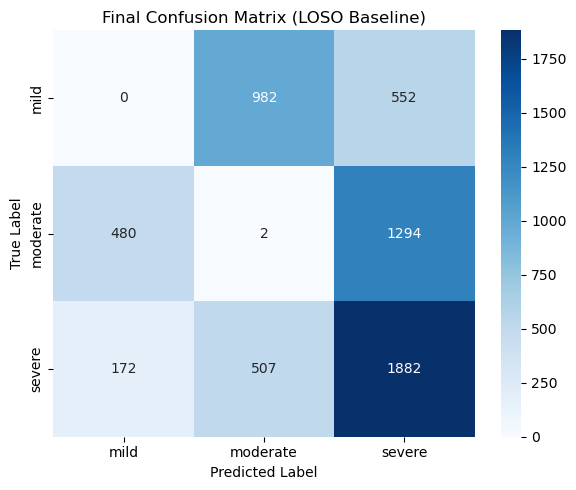

💾 Confusion matrix saved to: paper_figures\final_confusion_matrix.png


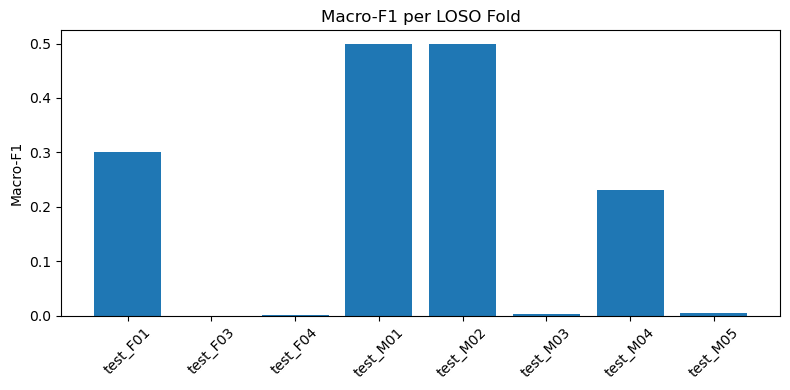

💾 Saved: paper_figures\macro_f1_per_fold.png


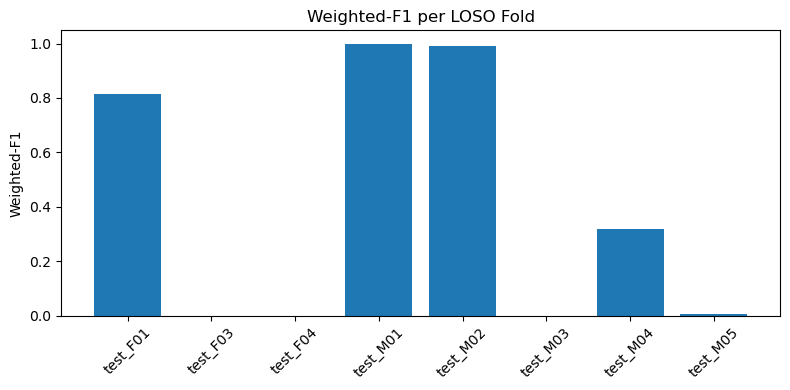

💾 Saved: paper_figures\weighted_f1_per_fold.png


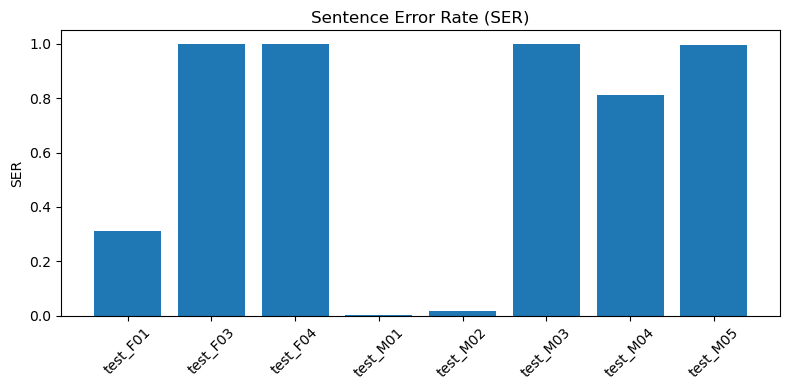

💾 Saved: paper_figures\ser_per_fold.png


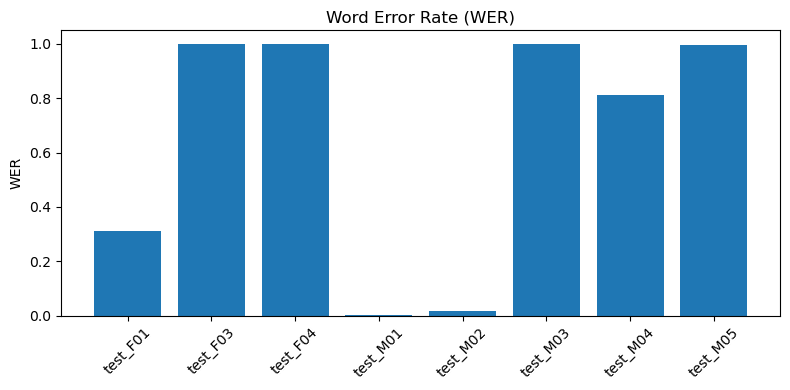

💾 Saved: paper_figures\wer_per_fold.png


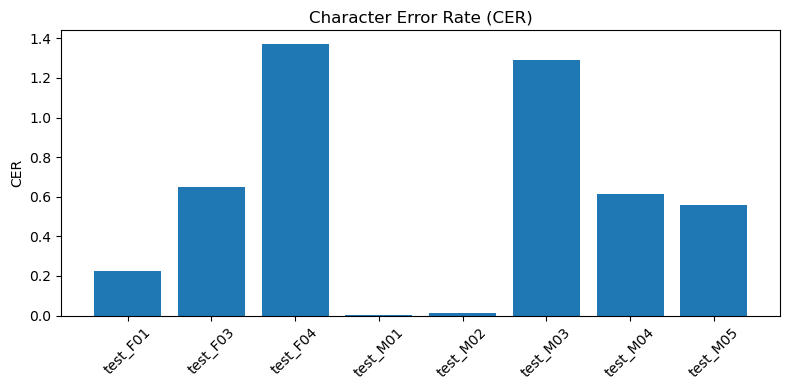

💾 Saved: paper_figures\cer_per_fold.png

📌 FINAL BASELINE SUMMARY (Mean ± Std)
Macro-F1   : 0.1925 ± 0.2079
Weighted-F1: 0.3912 ± 0.4361
SER        : 0.6424
WER        : 0.6424
CER        : 0.5899

🎉 FINAL EVALUATION & FIGURES COMPLETED
📁 All figures saved in: paper_figures


In [31]:
# ============================================================
# FINAL PAPER-READY EVALUATION & PLOTS
# Uses: baseline_final_loso_results.json
# Outputs: Confusion Matrix + Metric Plots
# ============================================================

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ===============================
# CONFIG
# ===============================
RESULTS_JSON = Path("baseline_final_loso_results.json")
FIG_DIR = Path("paper_figures")
FIG_DIR.mkdir(exist_ok=True)

CLASS_NAMES = ["mild", "moderate", "severe"]

print("📥 Loading results...")
with open(RESULTS_JSON) as f:
    results = json.load(f)

print(f"✅ Loaded {len(results)} LOSO folds")

# ===============================
# AGGREGATE CONFUSION MATRIX
# ===============================
print("📊 Aggregating confusion matrices...")

final_cm = np.zeros((3, 3), dtype=int)

for r in results:
    final_cm += np.array(r["confusion_matrix"])

print("✅ Final Confusion Matrix:")
print(final_cm)

# ===============================
# PLOT CONFUSION MATRIX
# ===============================
plt.figure(figsize=(6,5))
sns.heatmap(
    final_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Final Confusion Matrix (LOSO Baseline)")
plt.tight_layout()

cm_path = FIG_DIR / "final_confusion_matrix.png"
plt.savefig(cm_path, dpi=300)
plt.show()

print(f"💾 Confusion matrix saved to: {cm_path}")

# ===============================
# COLLECT METRICS
# ===============================
folds = []
macro_f1 = []
weighted_f1 = []
ser = []
wer = []
cer = []

for r in results:
    folds.append(r["fold"])
    macro_f1.append(r["best_macro_f1"])
    weighted_f1.append(r["weighted_f1"])
    ser.append(r["SER"])
    wer.append(r["WER"])
    cer.append(r["CER"])

# ===============================
# METRIC PLOTS
# ===============================
def plot_metric(values, title, ylabel, filename):
    plt.figure(figsize=(8,4))
    plt.bar(folds, values)
    plt.xticks(rotation=45)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    path = FIG_DIR / filename
    plt.savefig(path, dpi=300)
    plt.show()
    print(f"💾 Saved: {path}")

plot_metric(macro_f1, "Macro-F1 per LOSO Fold", "Macro-F1", "macro_f1_per_fold.png")
plot_metric(weighted_f1, "Weighted-F1 per LOSO Fold", "Weighted-F1", "weighted_f1_per_fold.png")
plot_metric(ser, "Sentence Error Rate (SER)", "SER", "ser_per_fold.png")
plot_metric(wer, "Word Error Rate (WER)", "WER", "wer_per_fold.png")
plot_metric(cer, "Character Error Rate (CER)", "CER", "cer_per_fold.png")

# ===============================
# PRINT FINAL SUMMARY (FOR PAPER)
# ===============================
print("\n📌 FINAL BASELINE SUMMARY (Mean ± Std)")
print(f"Macro-F1   : {np.mean(macro_f1):.4f} ± {np.std(macro_f1):.4f}")
print(f"Weighted-F1: {np.mean(weighted_f1):.4f} ± {np.std(weighted_f1):.4f}")
print(f"SER        : {np.mean(ser):.4f}")
print(f"WER        : {np.mean(wer):.4f}")
print(f"CER        : {np.mean(cer):.4f}")

print("\n🎉 FINAL EVALUATION & FIGURES COMPLETED")
print(f"📁 All figures saved in: {FIG_DIR}")
